# Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

## Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pylab as plt

In [2]:
df_ecommerce = pd.read_csv('cleaned_ecommerce_dataset.csv')
print(len(df_ecommerce))

2685


## Explore the Dataset

In [3]:
df_ecommerce.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category,item_id,item_price,user_city
0,4081,71900,Not always McCrap,McDonald's,4.0,3.0,M,Restaurants & Gourmet,41,30.74,4
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,1.0,4.0,M,Restaurants & Gourmet,74,108.30,4
2,4081,72000,The Wonderful World of Wendy,Wendy's,5.0,4.0,M,Restaurants & Gourmet,84,69.00,4
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",5.0,3.0,M,Movies,68,143.11,4
4,4081,100399,Hey! Gimme some pie!,American Pie,3.0,3.0,M,Movies,6,117.89,4


In [4]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   rating       2685 non-null   float64
 5   helpfulness  2685 non-null   float64
 6   gender       2685 non-null   object 
 7   category     2685 non-null   object 
 8   item_id      2685 non-null   int64  
 9   item_price   2685 non-null   float64
 10  user_city    2685 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 230.9+ KB


In [5]:
enc = OrdinalEncoder(dtype=int)
df_ecommerce[['gender_code']] = enc.fit_transform(df_ecommerce[['gender']])
df_ecommerce[['category_code']] = enc.fit_transform(df_ecommerce[['category']])
df_ecommerce[['review_code']] = enc.fit_transform(df_ecommerce[['review']])

In [6]:
df_ecommerce[['helpfulness', 'gender_code', 'category_code', 'review_code', 'rating']].corr()

,helpfulness,gender_code,category_code,review_code,rating
helpfulness,1.000000,0.075947,-0.013408,-0.028259,-0.007523
gender_code,0.075947,1.000000,0.022549,-0.037884,-0.034337
category_code,-0.013408,0.022549,1.000000,0.001970,-0.163158
review_code,-0.028259,-0.037884,0.001970,1.000000,-0.036118
rating,-0.007523,-0.034337,-0.163158,-0.036118,1.000000


In [7]:
corr_helpfulness = df_ecommerce['helpfulness'].corr(df_ecommerce['rating'])
corr_gender = df_ecommerce['gender_code'].corr(df_ecommerce['rating'])
corr_category = df_ecommerce['category_code'].corr(df_ecommerce['rating'])
corr_review = df_ecommerce['review_code'].corr(df_ecommerce['rating'])

print('corr_category', corr_category)
print('corr_review', corr_review)
print('corr_helpfulness', corr_helpfulness)
print('corr_gender', corr_gender)


corr_category -0.16315765340915656
corr_review -0.036118386552122385
corr_helpfulness -0.007523337726844546
corr_gender -0.03433661424208265


### Analysis
The highest correlation appears to be category, however it is weak (correlation = -0.163). The 2nd highest correlation appears to be review, however it is weak (correlation = -0.036). 

The lowest correlation appears to be helpfulness (correlation = -0.01) The 2nd lowest correlation appears to be gender (correlation = -0.034). 

All the variables—category, review, helpfulness, and gender—show a weak negative correlation with the rating, suggesting they have minimal influence on it.

The extremely low correlation coefficients imply that these variables are largely unrelated to the rating in a linear sense.

## Split Training and Testing Data
* Case 1: training data containing 10% of the entire data;
* Case 2: training data containing 90% of the entire data.

In [9]:
# Case 1 - training with 10%
train_case1, test_case1 = train_test_split(df_ecommerce, test_size=0.9, random_state=142)
print('train shape', train_case1.shape)
print('test shape', test_case1.shape)

# Case 1 - training with 90%
train_case2, test_case2 = train_test_split(df_ecommerce, test_size=0.1, random_state=142)
print('train shape', train_case2.shape)
print('test shape', test_case2.shape)

train shape (268, 14)
test shape (2417, 14)
train shape (2416, 14)
test shape (269, 14)


## Train Linear Regression Models with Feature Selection under Cases 1 & 2
* (model-a) using the training/testing data in case 1 with two most correlated input features
* (model-b) using the training/testing data in case 1 with two least correlated input features
* (model-c) using the training/testing data in case 2 with two most correlated input features
* (model-d) using the training/testing data in case 2 with two least correlated input features

In [10]:
# (model-a) using the training/testing data in case 1 with two most correlated input features

reg_M1 = linear_model.LinearRegression()

X_train_M1 = train_case1[['category_code','review_code']]
y_train_M1 = train_case1['rating']

X_test_M1 = test_case1[['category_code','review_code']]
y_test_M1 = test_case1['rating']

reg_M1.fit(X_train_M1,y_train_M1)

LinearRegression()

In [11]:
# (model-b) using the training/testing data in case 1 with two least correlated input features

reg_L1 = linear_model.LinearRegression()

X_train_L1 = train_case1[['helpfulness', 'gender_code']]
y_train_L1 = train_case1['rating']

X_test_L1 = test_case1[['helpfulness', 'gender_code']]
y_test_L1 = test_case1['rating']

reg_L1.fit(X_train_L1, y_train_L1)

LinearRegression()

In [12]:
# (model-c) using the training/testing data in case 2 with two most correlated input features

reg_M2 = linear_model.LinearRegression()

X_train_M2 = train_case2[['category_code', 'review_code']]
y_train_M2 = train_case2['rating']

X_test_M2 = test_case2[['category_code', 'review_code']]
y_test_M2 = test_case2['rating']

reg_M2.fit(X_train_M2, y_train_M2)

LinearRegression()

In [13]:
# (model-d) using the training/testing data in case 2 with two least correlated input features

reg_L2 = linear_model.LinearRegression()

X_train_L2 = train_case2[['helpfulness', 'gender_code']]
y_train_L2 = train_case2['rating']

X_test_L2 = test_case2[['helpfulness', 'gender_code']]
y_test_L2 = test_case2['rating']

reg_L2.fit(X_train_L2, y_train_L2)

LinearRegression()

## Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE

In [14]:
from sklearn.metrics import mean_squared_error

In [15]:
predicted_M1 = reg_M1.predict(X_test_M1)
mse_M1 = mean_squared_error(predicted_M1, y_test_M1)
rmse_M1 = np.sqrt(mse_M1)
print('Model-A')
print(f'reg_M1 MSE: {round(mse_M1, 4):>7}')
print(f'reg_M1 RMSE: {round(rmse_M1, 4):>6}')
print()

predicted_L1 = reg_L1.predict(X_test_L1)
mse_L1 = mean_squared_error(predicted_L1, y_test_L1)
rmse_L1 = np.sqrt(mse_L1)
print('Model-B')
print(f'reg_L1 MSE: {round(mse_L1, 4):>7}')
print(f'reg_L1 RMSE: {round(rmse_L1, 4):>6}')
print()

predicted_M2 = reg_M2.predict(X_test_M2)
mse_M2 = mean_squared_error(predicted_M2, y_test_M2)
rmse_M2 = np.sqrt(mse_M2)
print('Model-C')
print(f'reg_M2 MSE: {round(mse_M2, 4):>7}')
print(f'reg_M2 RMSE: {round(rmse_M2, 4):>6}')
print()

predicted_L2 = reg_L2.predict(X_test_L2)
mse_L2 = mean_squared_error(predicted_L2, y_test_L2)
rmse_L2 = np.sqrt(mse_L2)
print('Model-D')
print(f'reg_L2 MSE: {round(mse_L2, 4):>7}')
print(f'reg_L2 RMSE: {round(rmse_L2, 4):>6}')
print()


Model-A
reg_M1 MSE:  1.7691
reg_M1 RMSE: 1.3301

Model-B
reg_L1 MSE:  1.8413
reg_L1 RMSE: 1.3569

Model-C
reg_M2 MSE:  1.7589
reg_M2 RMSE: 1.3262

Model-D
reg_L2 MSE:  1.8109
reg_L2 RMSE: 1.3457



## Visualize, Compare and Analyze the Results

In [16]:
mse_df = pd.DataFrame({'mse':[mse_M1, mse_L1, mse_M2, mse_L2]}, index = ['Model-A', 'Model-B', 'Model-C', 'Model-D'])

In [17]:
rsme_df = pd.DataFrame({'rmse':[rmse_M1, rmse_L1, rmse_M2, rmse_L2]}, index = ['Model-A', 'Model-B', 'Model-C', 'Model-D'])

In [18]:
mse_df

,mse
Model-A,1.769074
Model-B,1.841255
Model-C,1.758898
Model-D,1.810946


In [19]:
rsme_df

,rmse
Model-A,1.330065
Model-B,1.356929
Model-C,1.326234
Model-D,1.345714


<BarContainer object of 4 artists>

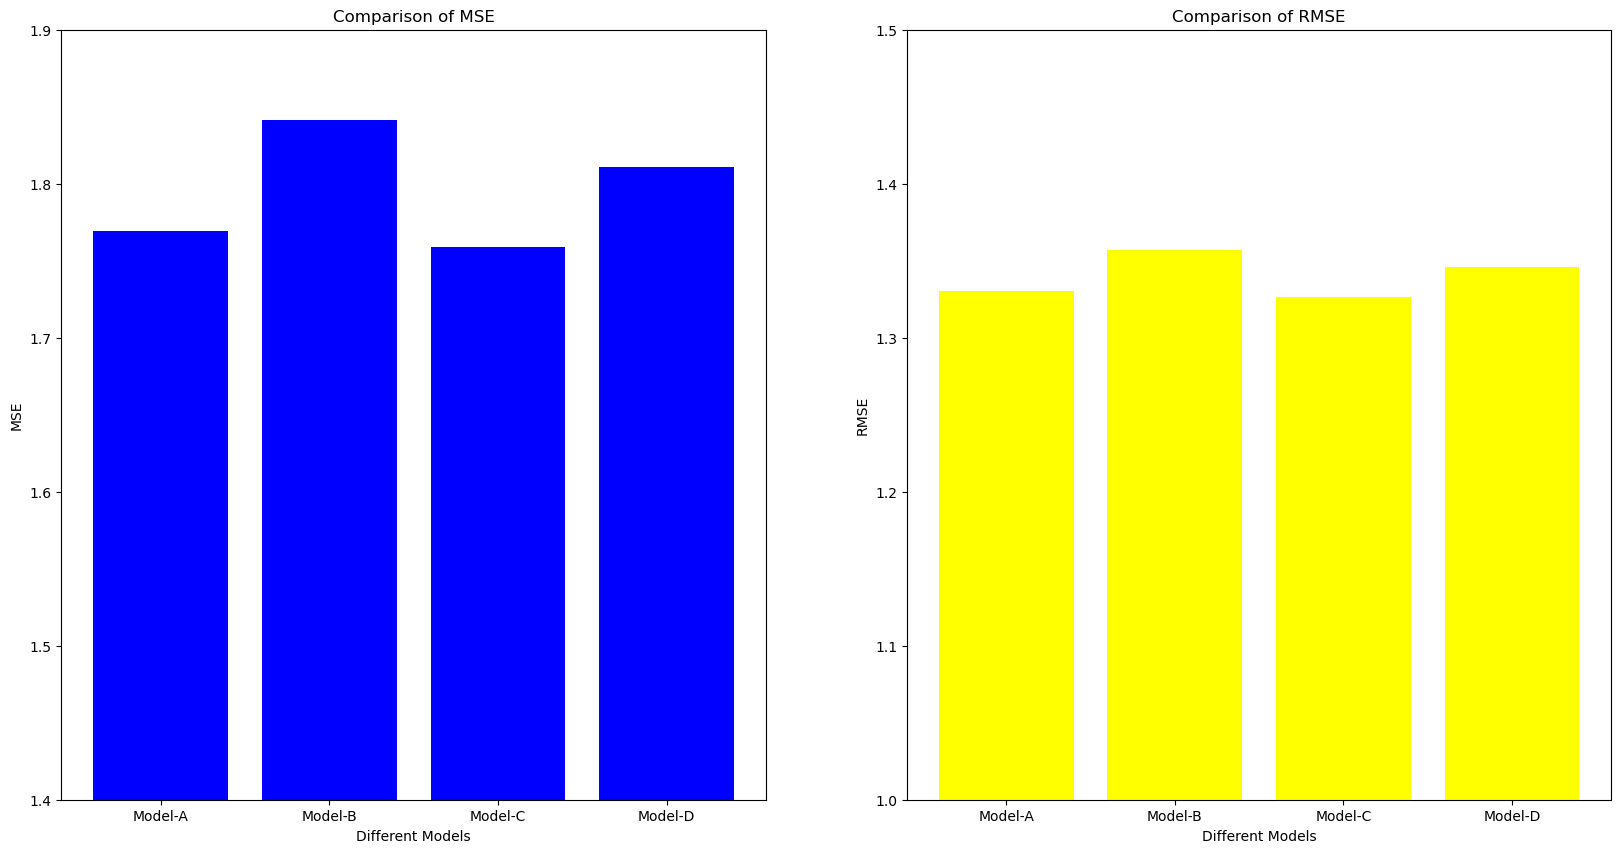

In [20]:
plt.figure(figsize = (20,10))
# subplot 1 mse
plt.subplot(1,2,1)
plt.ylabel('MSE')
plt.xlabel('Different Models')
plt.title('Comparison of MSE')
plt.ylim(1.4, 1.9)
plt.bar(data = mse_df, x = ['Model-A', 'Model-B', 'Model-C', 'Model-D'], height = 'mse', color = 'blue')

# subplot 2 rsme
plt.subplot(1,2,2)
plt.ylabel('RMSE')
plt.xlabel('Different Models')
plt.title('Comparison of RMSE')
plt.ylim(1, 1.5)
plt.bar(data = rsme_df, x = ['Model-A', 'Model-B', 'Model-C', 'Model-D'], height = 'rmse', color = 'yellow')

### Insightful Analysis

In the comparison between Model A (reg_M1) and Model C (reg_M2), as well as between Model B (reg_L1) and Model D (reg_L2), it's observed that a lower MSE is associated with models that have more training data. This suggests that having more data improves the accuracy of the predictions.

When comparing Model A (reg_M1) with Model B (reg_L1), and Model C (reg_M2) with Model D (reg_L2), we see that models with more correlated input features yield lower MSE and RMSE values, indicating a better quality of prediction.

These observations hold true for both MSE and RMSE metrics. However, despite these relative differences, the overall performance of all four models is modest, likely due to the weak correlation each has with the rating variable.